## Comparision of  MC estimate of statistics using Fipy(ground truth) vs statistics by Deep Neural Network with 'n samples' each

In [1]:
#load libraries 
from __future__ import division
import argparse

import matplotlib
matplotlib.use('PS')
%matplotlib inline
import tensorflow as tf
import random 
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import Model
from keras.layers import Dense, Activation, Input, concatenate, Lambda, Add
from keras.utils import plot_model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt 
import GPy
from fipy import *
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
import seaborn as sns 
sns.set_context('paper')
sns.set_style('white')
from pdb import set_trace as keyboard
import sys
import time
# plt.rcParams["patch.force_edgecolor"] = True

/Users/sharmila/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# maindir='/Users/sharmila/Desktop/research/work/03_NN_PDE/Level3/part8_image/2_2dim_c=0_f=0'
# Taking needed inputs and loading files

# Load files
# load cellcenters data
cellcenters = np.load('cellcenters_nx1=32_nx2=32.npy')
# load MC input samples [conductivity] # these inputs are already bounded.
MC_inputfield = np.load('MC_samples_inputfield_exp_nx1=32_nx2=32_lx1=0.06_lx2=0.15_v=0.75_num_samples=100000.npy')
# load MC samples fipy # the below fipy file is for bounded inputs itself.
MC_u_fipy = np.load('MC_samples_u_fipy_exp_nx1=32_nx2=32_lx1=0.06_lx2=0.15_v=0.75_num_samples=100000.npy')

# DNN surrogate inputs
############################
DNN_type = 'Resnet'
act_func = 'swish'
n = 500 # Number of neurons in each block
num_block = 3 # Number of blocks
############################
DNN_weights_path='my_model_weights.h5'

In [3]:
print cellcenters.shape
print MC_inputfield.shape
print MC_u_fipy.shape

(1024, 2)
(100000, 1024)
(100000, 1024)


In [4]:
print np.shape(cellcenters)
# print cellcenters

nx1=int(np.sqrt(cellcenters.shape[0]))
nx2=int(np.sqrt(cellcenters.shape[0]))
print nx1
print nx2

x1_f = cellcenters[:,0][:,None] # x1-coordinates of cell centers (nx1*nx2,1) matrix
x2_f = cellcenters[:,1][:,None] # x2-coordinates of cell centers (nx1*nx2,1) matrix
print np.shape(x1_f)
print np.shape(x2_f)
# print x1_f
# print x2_f

(1024, 2)
32
32
(1024, 1)
(1024, 1)


In [5]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["navy","blue","deepskyblue","limegreen","yellow","darkorange","red","maroon"])

### A.ground_using_fipy

In [6]:
print MC_u_fipy.shape
print MC_u_fipy

ground_mean_fipy=np.mean(MC_u_fipy,axis=0)
ground_var_fipy=np.var(MC_u_fipy,axis=0)
print ground_mean_fipy.shape
print ground_var_fipy.shape

(100000, 1024)
[[0.99087423 0.9702004  0.94202792 ... 0.06269906 0.02925315 0.00937476]
 [0.9726409  0.92827975 0.90780617 ... 0.12006111 0.08722236 0.03291061]
 [0.98952637 0.96540946 0.93113733 ... 0.09109914 0.05416199 0.01731823]
 ...
 [0.96884139 0.91382506 0.86300427 ... 0.01945292 0.01054741 0.00395004]
 [0.97936834 0.92858416 0.8901669  ... 0.10457129 0.08557196 0.02566467]
 [0.98921523 0.97050475 0.95178099 ... 0.08126978 0.05630799 0.01909373]]
(1024,)
(1024,)


 /Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


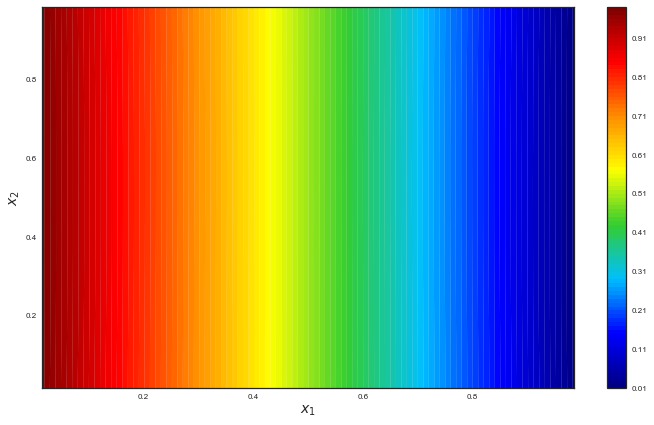

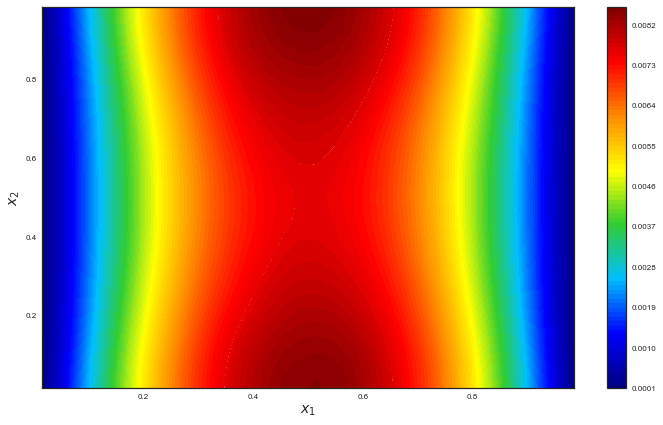

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
c = ax.contourf(x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), ground_mean_fipy.reshape((nx1,nx2)),100,cmap=cmap)   # set levels as previous levels
# This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
for j in c.collections:
    j.set_edgecolor("face")
plt.colorbar(c)
# plt.title('mean: fipy')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'mean_fipy.pdf'))
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
c = ax.contourf(x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), ground_var_fipy.reshape((nx1,nx2)),100,cmap=cmap)   # set levels as previous levels
# This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
for j in c.collections:
    j.set_edgecolor("face")
plt.colorbar(c)
# plt.title('variance: fipy')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'variance_fipy.pdf'))
plt.show()

(100000,)
[0.515625]
[0.515625]


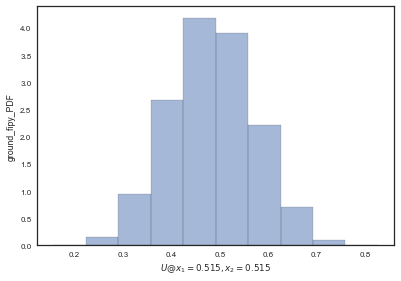

In [8]:
## mid point x1=0.515,x2=0.515 statistics #location A
print MC_u_fipy[:,528].shape
print x1_f[528]
print x2_f[528]

fig, ax = plt.subplots()
ax.hist(MC_u_fipy[:,528], normed=True, alpha=0.5)
ax.set_xlabel('$U@x_1=0.515,x_2=0.515$')
ax.set_ylabel('ground_fipy_PDF')
plt.show()

(100000,)
[0.359375]
[0.734375]


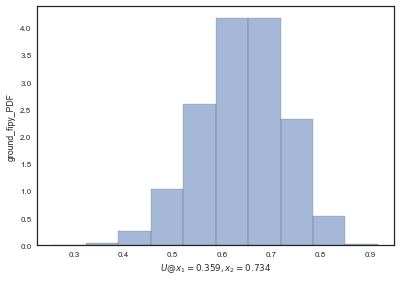

In [9]:
## x1=0.359,x2=0.734 statistics #location B
print MC_u_fipy[:,747].shape
print x1_f[747]
print x2_f[747]

fig, ax = plt.subplots()
ax.hist(MC_u_fipy[:,747], normed=True, alpha=0.5)
ax.set_xlabel('$U@x_1=0.359,x_2=0.734$')
ax.set_ylabel('ground_fipy_PDF')
plt.show()

### B.Neural_network

In [10]:
# ======================
##giving_DNN_architecture
# ------------------------------------------------------------

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})
# ------------------------------------------------------------
# BUILDING DNN APPROXIMATOR
# ======================
# DNN network i/p:x1,x2,A o/p:prediction

x1 = Input(shape=(1,))
x2 = Input(shape=(1,))
A = Input(shape=(nx1*nx2,)) # input field image: conductivity image
a_val = Input(shape=(1,)) # input field value: conductivity value at the corresponding 'input(x1,x2)' location

if DNN_type == 'Resnet':
    x1_x2_A = concatenate([x1,x2,A])
    o = Dense(n)(x1_x2_A)
    for i in range(num_block):
        z = Dense(n, activation = act_func)(o)
        z = Dense(n, activation = act_func)(z)
        o = Add()([z, o])
    prediction = Dense(1)(o)
    print DNN_type

elif DNN_type == 'FC':
    num_neurons_per_layer = map(int, d.strip('[]').split(','))
    x1_x2_A = concatenate([x1,x2,A])
    z = Dense(num_neurons_per_layer[0], activation=act_func)(x1_x2_A)
    for n in num_neurons_per_layer[1:]:
        z = Dense(n, activation=act_func)(z)
    prediction = Dense(1)(z)
    print DNN_type

def myFunc(t):
    return ((1-t[0])+(t[0]*(1-t[0])*t[2])) # dirichlet on left and right sides of plate

u = Lambda(myFunc, output_shape=(1,))([x1,x2,prediction]) # field of interest : temperature
model = Model(inputs=[x1,x2,A], outputs=u)


Instructions for updating:
Colocations handled automatically by placer.
Resnet


In [11]:
init = tf.global_variables_initializer()   
sess = tf.Session()
K.set_session(sess)
sess.run(init) 

print('-------')
model.load_weights(DNN_weights_path)##loading saved weights of the model
# for layer in model.layers:
#     g=layer.get_config()
#     h=layer.get_weights()
#     print (g)
#     print (h)

-------


In [12]:
# start = time.time()

# nsamples = MC_inputfield.shape[0]

# MC_samples_u_DNN = np.zeros((nsamples, nx1*nx2))  ##evaluating at cell centers

# for i in xrange(nsamples):
#     #display
#     if (i+1)%10000 == 0:
#         print "Predicting MC sample "+str(i+1)
        
#     a = MC_inputfield[ i , : ].reshape(-1,1)

#     u_DNN = sess.run(u, feed_dict={x1:x1_f, x2:x2_f,  A:np.repeat(a.T, np.shape(x1_f)[0], axis=0)})
#     MC_samples_u_DNN[i] = u_DNN.flatten()
    
# finish = time.time() - start
# print "Time (sec) to generate "+str(MC_inputfield.shape[0])+" MC samples using DNN: " +str(finish)

# np.save('MC_samples_u_DNN_exp_nx1=32_nx2=32_lx1=0.06_lx2=0.15_v=0.75_num_samples=100000.npy',MC_samples_u_DNN)

In [7]:
MC_u_DNN = np.load('MC_samples_u_DNN_exp_nx1=32_nx2=32_lx1=0.06_lx2=0.15_v=0.75_num_samples=100000.npy')

In [8]:
print MC_u_DNN.shape
print MC_u_DNN

mean_DNN = np.mean(MC_u_DNN,axis=0)
var_DNN = np.var(MC_u_DNN,axis=0)
print mean_DNN.shape
print var_DNN.shape

(100000, 1024)
[[0.99035931 0.97241759 0.94818342 ... 0.09941497 0.06230617 0.02189842]
 [0.9729445  0.93638349 0.91072005 ... 0.12503321 0.08607867 0.03291437]
 [0.97365671 0.92074203 0.86974591 ... 0.1131736  0.07209402 0.02575429]
 ...
 [0.98049337 0.93885046 0.89401937 ... 0.02314791 0.00997457 0.00238456]
 [0.98321748 0.94834071 0.9122349  ... 0.11248954 0.06793577 0.0227452 ]
 [0.98802626 0.96448725 0.94100344 ... 0.10868421 0.0625295  0.02000179]]
(1024,)
(1024,)


 /Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


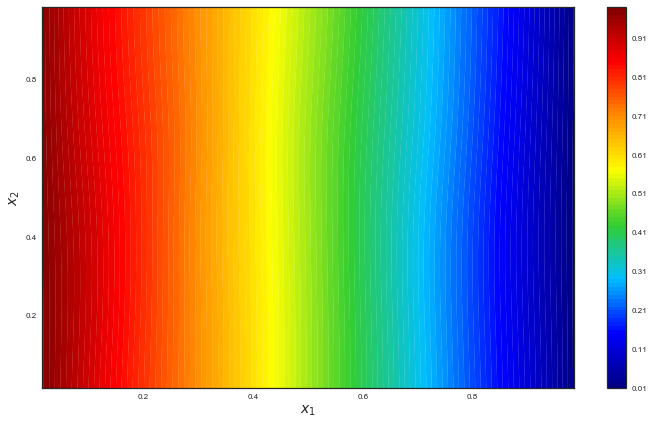

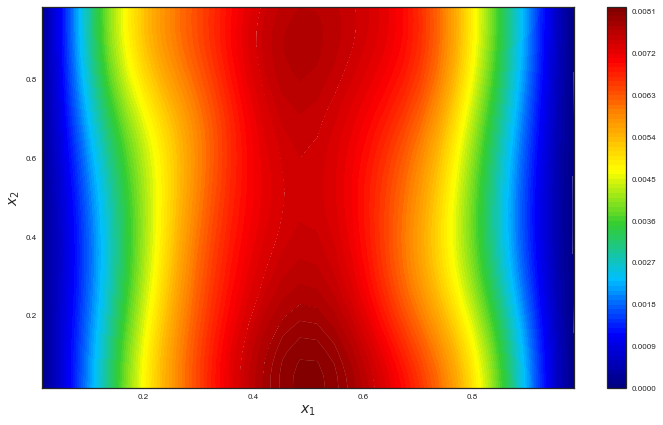

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
c = ax.contourf(x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), mean_DNN.reshape((nx1,nx2)),100,cmap=cmap)   # set levels as previous levels
# This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
for j in c.collections:
    j.set_edgecolor("face")
plt.colorbar(c)
# plt.title('mean: fipy')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'mean_DNN.pdf'))
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
c = ax.contourf(x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), var_DNN.reshape((nx1,nx2)),100,cmap=cmap)   # set levels as previous levels
# This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
for j in c.collections:
    j.set_edgecolor("face")
plt.colorbar(c)
# plt.title('variance: fipy')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'variance_DNN.pdf'))
plt.show()

(100000,)
[0.515625]
[0.515625]


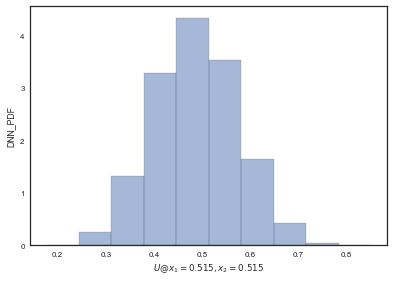

In [16]:
## mid point x1=0.515,x2=0.515 statistics #location A
print MC_u_DNN[:,528].shape
print x1_f[528]
print x2_f[528]

fig, ax = plt.subplots()
ax.hist(MC_u_DNN[:,528], normed=True, alpha=0.5)
ax.set_xlabel('$U@x_1=0.515,x_2=0.515$')
ax.set_ylabel('DNN_PDF')
plt.show()

(100000,)
[0.359375]
[0.734375]


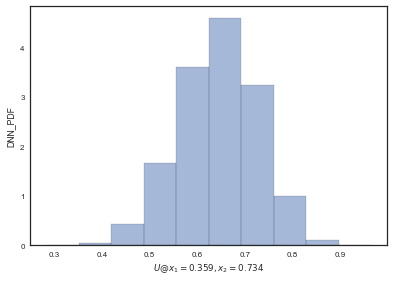

In [17]:
## x1=0.359,x2=0.734 statistics #location B
print MC_u_DNN[:,747].shape
print x1_f[747]
print x2_f[747]

fig, ax = plt.subplots()
ax.hist(MC_u_DNN[:,747], normed=True, alpha=0.5)
ax.set_xlabel('$U@x_1=0.359,x_2=0.734$')
ax.set_ylabel('DNN_PDF')
plt.show()

### C.Comparing Fipy vs NN

 /Users/sharmila/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


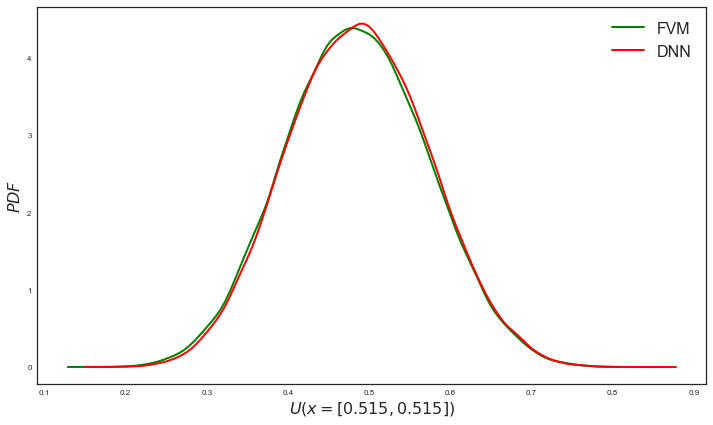

In [10]:
plt.rc('legend', fontsize=16) 
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(MC_u_fipy[:,528], bins =100, norm_hist = True,label='FVM', color="green", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
sns.distplot(MC_u_DNN[:,528], bins =100, norm_hist = True,label='DNN',color="red", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
ax.set_xlabel(r'$U(x=[0.515,0.515])$', fontsize = 16)
ax.set_ylabel('$PDF$', fontsize = 16)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'PDF@x=locA_fipy_vs_DNN.pdf'))

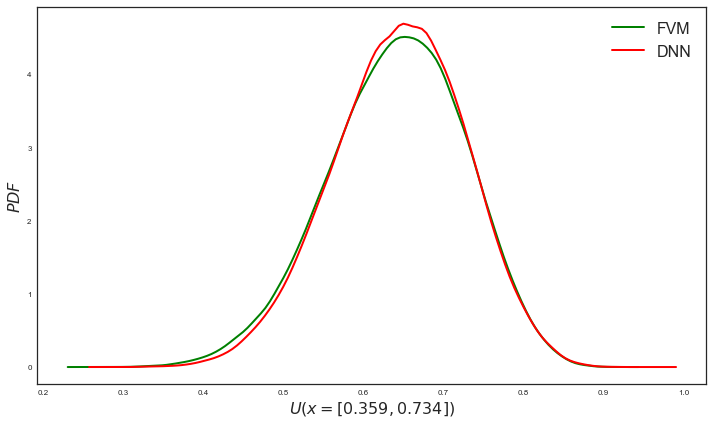

In [11]:
plt.rc('legend', fontsize=16) 
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(MC_u_fipy[:,747], bins =100, norm_hist = True,label='FVM', color="green", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
sns.distplot(MC_u_DNN[:,747], bins =100, norm_hist = True,label='DNN',color="red", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
ax.set_xlabel(r'$U(x=[0.359,0.734])$', fontsize = 16)
ax.set_ylabel('$PDF$', fontsize = 16)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'PDF@x=locB_fipy_vs_DNN.pdf'))

##### Relative L2 Error
Let $\mathbf{y}_{\mbox{true}}$ be the *ground truth vector* from fipy and $\hat{\mathbf{y}}$ be the *estimated vector* from neural network.
The relattive L2 error is defined to be:
$$
L_2[\mathbf{y}_{\mbox{true}},\hat{\mathbf{y}}] = \frac{\parallel\mathbf{y}_{\mbox{true}}-\hat{\mathbf{y}} \parallel_2}{\parallel \mathbf{y}_{\mbox{true}}\parallel_2},
$$
where $\parallel\cdot\parallel_2$ is the standard Euclidean norm.

In [20]:
## Relative L2 error in the mean and variance
y_true_mean=ground_mean_fipy
y_true_var=ground_var_fipy

y_cap_mean = mean_DNN
y_cap_var = var_DNN

L2_mean=(np.linalg.norm(y_true_mean-y_cap_mean) / np.linalg.norm(y_true_mean))
L2_var=(np.linalg.norm(y_true_var-y_cap_var) / np.linalg.norm(y_true_var))

print L2_mean
print L2_var 

0.012412722133299496
0.0711747211525895


In [21]:
from sklearn.metrics import r2_score
print r2_score(y_true_mean,y_cap_mean) 
print r2_score(y_true_var,y_cap_var)

0.9993844542490015
0.9763019938532028


In [22]:
### checking

In [23]:
# checking
print('*******')
h=[]
for i in xrange(MC_u_DNN.shape[0]):
    j=np.amax(MC_u_DNN[i,:])
    if j>=1.05:
        print j
        h.append(i)
print('*******')
print h
print len(h)
    

*******
*******
[]
0


In [24]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_pages = PdfPages('badplots.pdf')
for p in xrange(len(h)):
    # Initialize the plot
    fig = plt.figure(figsize=(18,6))

    try:
        ax1.lines.remove(c1[0])
        ax2.lines.remove(c2[0])
        ax3.lines.remove(c3[0])

    except:
        pass

    ax1 = fig.add_subplot(1, 3, 1)
    c1 = ax1.contourf( x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), np.log(MC_inputfield)[h[p],:].reshape((nx1,nx2)), 100, cmap=cmap)   # set levels automatically
    # This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
    for j in c1.collections:
        j.set_edgecolor("face")
    plt.colorbar(c1)
    plt.title('$log(Input \ field)$', fontsize=14)
    plt.xlabel('$x1$', fontsize=12)
    plt.ylabel('$x2$', fontsize=12)


    ax2 = fig.add_subplot(1, 3, 2)
    c2 = ax2.contourf( x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), MC_u_fipy[h[p],:].reshape((nx1,nx2)), 100, cmap=cmap)  # set levels as previous levels
    # This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
    for j in c2.collections:
        j.set_edgecolor("face")
    plt.colorbar(c2)
    plt.title('$FVM \ solution$',fontsize=14)
    plt.xlabel('$x1$', fontsize=12)
    plt.ylabel('$x2$', fontsize=12)


    ax3 = fig.add_subplot(1, 3, 3)
    c3 = ax3.contourf( x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), MC_u_DNN[h[p],:].reshape((nx1,nx2)), 100, cmap=cmap)   # set levels automatically
    # This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
    for j in c3.collections:
        j.set_edgecolor("face")
    plt.colorbar(c3)
    plt.title('$DNN \ solution$', fontsize=14)
    plt.xlabel('$x1$', fontsize=12)
    plt.ylabel('$x2$', fontsize=12)

    plt.tight_layout()
    plt.suptitle('test_case='+str(h[p]), fontsize=12) #indexed from 0
#     plt.savefig(os.path.join(resultdir,'test_case='+str(i+1)+'_DNN_type='+str(DNN_type)+'_nx1*nx2='+str(nx1*nx2)+'_seed='+str(seed)+'_'+str(variation)+'_nnpred-fipy.pdf')) 
    pdf_pages.savefig(fig)
    plt.show()
# # Write the PDF document to the disk
pdf_pages.close()
#check